<a href="https://colab.research.google.com/github/Athish2210/CAR-RECO-USING-GENSIM-AND-LDA/blob/main/CAR-RECO-USING-GENSIM-AND-LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import os 
import glob
from time import time
from nltk.stem import PorterStemmer, WordNetLemmatizer
#import nlp tools
import nltk, string,re
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.stem import PorterStemmer, WordNetLemmatizer
import gensim
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
all_files = glob.glob("/content/drive/MyDrive/Car-review/*.csv")

In [4]:
df_from_each_file = (pd.read_csv(f,lineterminator='\n',index_col=0) for f in all_files)
concatenated_df  = pd.concat(df_from_each_file, ignore_index=True)
# doesn't create a list, nor does it append to one
#Filtering the dataframe to capture only car years > 2010.
concatenated_df.Review_Date = concatenated_df.Vehicle_Title.apply(lambda x:x.split()[0])
concatenated_df.Review_Date = concatenated_df.Review_Date.apply(lambda x:pd.to_datetime(x))
concatenated_df['year'] = concatenated_df.Review_Date.dt.year
concatenated_df = concatenated_df[concatenated_df.year > 2010]
concatenated_df.shape

(29590, 7)

In [5]:
#Dropping the unncessary columns 
car_df = concatenated_df.drop(columns=['Review_Date','Author_Name','Review_Title','year'],axis=1)

#Renaming all the columns of the dataframe.
car_df.rename(columns={'Vehicle_Title':'vehicle','Review':'review','Rating\r':'rating'},inplace=True)
car_df.reset_index(drop=True, inplace=True)
car_df.head()

vehicle  \
0  2017 Lamborghini Huracan Convertible LP 580-2 ...   
1  2012 Lamborghini Gallardo Convertible LP 560-4...   
2  2011 Lamborghini Gallardo Coupe LP 570-4 Super...   
3  2017 Jeep Cherokee SUV Altitude 4dr SUV (2.4L ...   
4  2017 Jeep Cherokee SUV Latitude 4dr SUV 4WD (2...   

                                              review  rating  
0   I bought this car for my son and he loves it!...    5.00  
1   I've had many, many, many cars. From R8's to ...    5.00  
2   I recently purchased this vehicle and am extr...    4.75  
3   If the weather gets too hot you have to repla...    1.00  
4   Fuel economy could be better and a Jeep shoul...    5.00

In [6]:
#saving final dataframe as pickle file

with open('car_df', 'wb') as f: #change
    pickle.dump(car_df, f)         #change 
#Loading the pickled car dataframe
with open('car_df', 'rb') as f:
    car_df = pickle.load(f)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated

rating
1.0    167.083515
2.0    159.323772
3.0    155.877870
4.0    138.610003
5.0    117.299277
Name: text_length, dtype: float64

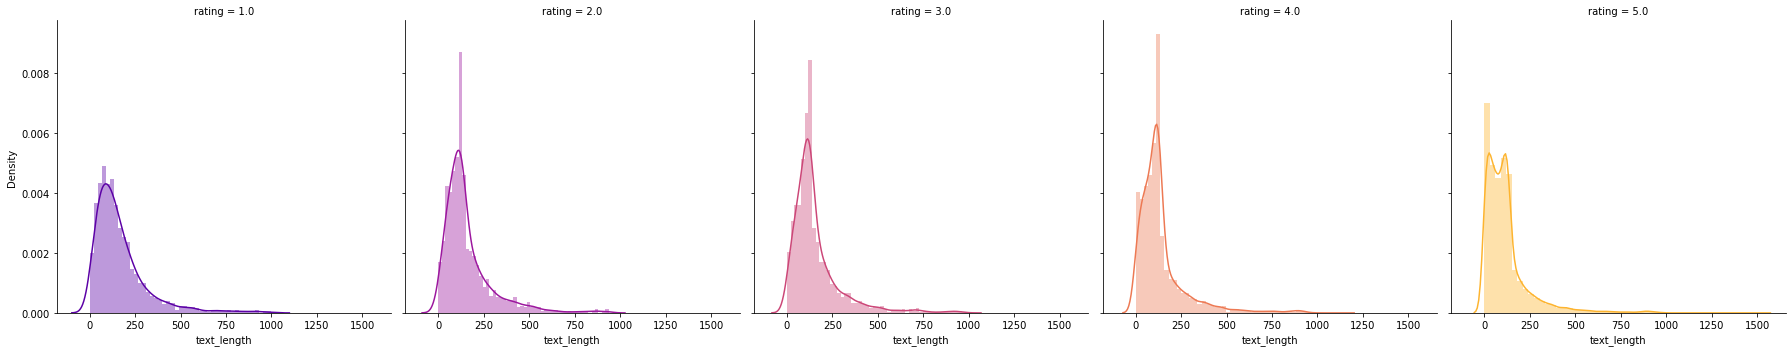

In [7]:
#Round ratings into whole numbers
car_df.rating = car_df.rating.apply(lambda x : np.round(x))
#Creating a text_length feature
car_df['text_length'] = car_df['review'].apply(lambda x:len(x.split()))
a = sns.FacetGrid(data = car_df, col = 'rating', hue = 'rating', palette='plasma', size=5)
a.map(sns.distplot, "text_length")
car_df.groupby('rating').mean()['text_length']

In [8]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
def lem(x):
    '''Lemmatizing the words'''
    lem = WordNetLemmatizer()
    lemma = [lem.lemmatize(t) for t in x]
    return lemma

def clean_text(x):
    '''Removing any punctuations'''
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_text2(x):
    '''Removing any words that are less than 3 letters'''
    pattern = r'\b\w{1,3}\b'
    text = re.sub(pattern,'',x)
    return x

def clean_numbers(x):
    '''More cleaning done'''
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '', x)
        x = re.sub('[0-9]{4}', '', x)
        x = re.sub('[0-9]{3}', '', x)
        x = re.sub('[0-9]{2}', '', x)
    return x

def lc_remove(text):
    '''Removing documents that are less than 3 words '''
    return ' '.join(word for word in text.split() if len(word)>3)

def removepunc(x):
    '''Removing punctuations'''
    return re.sub('[%s]' % re.escape(string.punctuation), ' ', x)

stop = stopwords.words('english');
stop.append('good')
stop.append('vehicle')
stop.append('great')
stop.append('ride')

In [10]:
car_df.review = car_df.review.apply(lambda x:removepunc(x))
car_df.review = car_df.review.str.lower().str.split()
car_df.review = car_df.review.apply(lambda x:[item for item in x if item not in stop])
car_df.review = car_df.review.apply(lambda x:[item for item in x if not item.isdigit()]);
car_df.review = car_df.review.apply(lambda x:lem(x))

In [11]:
car_df['text_length'] = car_df['review'].apply(lambda x:len(x))
car_df = car_df[car_df.text_length > 6]
car_df.reset_index(inplace=True,drop=True)

In [12]:
#Joining all the words in the review back to a string text.
car_df['review']=[" ".join(review) for review in car_df['review'].values]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated

rating
1.0    82.393653
2.0    79.062592
3.0    78.599047
4.0    73.015302
5.0    65.096561
Name: text_length, dtype: float64

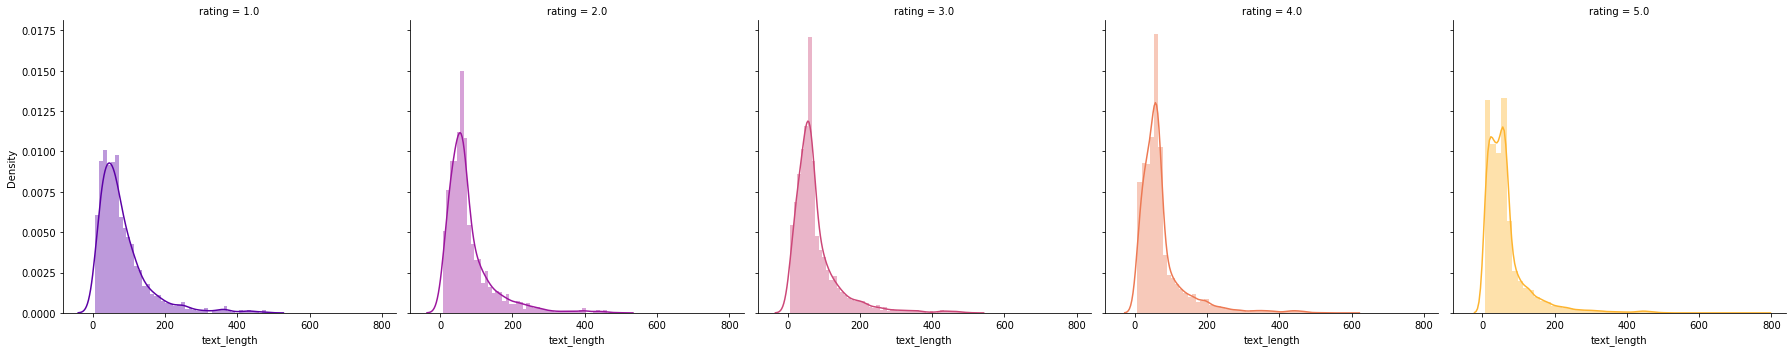

In [13]:
a = sns.FacetGrid(data = car_df, col = 'rating', hue = 'rating', palette='plasma', size=5)
a.map(sns.distplot, "text_length")
car_df.groupby('rating').mean()['text_length']

In [14]:
with open('car_df_cleaned', 'wb') as f: #change
    pickle.dump(car_df, f)         #change

In [15]:
!pip install --upgrade numpy==1.13.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.0 MB 5.1 MB/s 
  ERROR: Failed building wheel for numpy
  Running setup.py clean for numpy
  ERROR: Failed cleaning build dir for numpy
Failed to build numpy
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
    Running setup.py install for numpy ... error
  Rolling back uninstall of numpy
  Moving to /usr/bin/f2py
   from /tmp/pip-uninstall-lkj5q7qd/f2py
  Moving to /usr/local/bin/f2py
   from /tmp/pip-uninstall-zh7uio09/f2py
  Moving to /usr/local/bin/f2py3
   from /tmp/pip-uninstall-zh7uio09/f2py3
  Moving to /usr/local/bin/f2py3.7
   from /tmp/pip-uninstall-zh7uio09/f2py3.7
  Moving to /usr/local/lib/python3.7/dist-packages/numpy-1.21.6.dist-info/
   from /usr/local/lib/python3.7/dist-packages/~umpy-1.21.6.dist-info
  Moving to /usr/local/lib/p

In [16]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=47e92f6a6e228eb968142f5152857a14dbba760c214371f08e0ae1b04bb7c7c8
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=22cc5ac1c290db5f35792d2eb8da5e523d445dbc7a568300ff7f91e2b0cf590b
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pyLDAvis sklearn


In [42]:
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
pd.set_option('display.max_columns', 50)

import gensim
from gensim import models
import pprint
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

import nltk, string,re
from nltk.corpus import stopwords
from textblob import TextBlob
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import LdaMulticore

from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel

In [18]:
#Loading the pickled car dataframe
with open('car_df_cleaned', 'rb') as f:
    car_df = pickle.load(f)

In [19]:
#Vectorizing the pre-processed documents using Count Vec and TF-IDF Vect
vectorizer = TfidfVectorizer()
cv = CountVectorizer()

In [20]:
#Using Countvect
t0 = time()
count = cv.fit_transform(car_df.review).toarray()
print("done in %0.3fs." % (time() - t0))

done in 10.687s.


In [21]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(car_df['review'])
print("done in %0.3fs." % (time() - t0))

Extracting tf-idf features for NMF...
done in 1.976s.


In [22]:
tfidf_df = pd.DataFrame(tfidf.toarray(), columns = tfidf_vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [23]:
# Fit the NMF model
print("Fitting the NMF model with tf-idf features")
t0 = time()
model = NMF(n_components=10, random_state=1,
          alpha=.1, l1_ratio=.5)
nmf = model.fit_transform(tfidf)
print("done in %0.3fs." % (time() - t0))

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Fitting the NMF model with tf-idf features
done in 7.580s.


In [24]:
W = nmf
H = model.components_

In [25]:
# Helper functions for grabbing the topics
def get_descriptor(terms, H, topic_index, top):
    #reverse sort the values to sort the indices
    top_indices = np.argsort(H[topic_index,:])[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append(terms[term_index])
    return top_terms
    
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
def get_top_cars(df,W,topic_index,number):
    #getting reversed order of cars
    top_indices = np.argsort(W[:,topic_index])[::-1]
    
    top_cars = []
    for caridx in top_indices[0:number]:
        top_cars.append(df.iloc[caridx])
    return top_cars

In [26]:
print_top_words(model,tfidf_vectorizer.get_feature_names(),5)

Topic #0:
like drive feel interior love
Topic #1:
problem mile dealer issue time
Topic #2:
truck tacoma toyota tundra bed
Topic #3:
mpg mileage gas mile highway
Topic #4:
car love drive fun owned
Topic #5:
honda accord civic pilot crv
Topic #6:
seat back front room rear
Topic #7:
jeep cherokee wrangler grand patriot
Topic #8:
ford focus escape fusion explorer
Topic #9:
transmission nissan cvt manual speed



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [27]:
get_top_cars(car_df,W,0,5)

[vehicle        2016 BMW 3 Series Sedan 340i xDrive 4dr Sedan ...
 review         several month researching type different vehic...
 rating                                                       4.0
 text_length                                                  444
 Name: 16423, dtype: object,
 vehicle        2015 BMW 2 Series Coupe 228i SULEV 2dr Coupe (...
 review         update issue still enjoying car still say coul...
 rating                                                       4.0
 text_length                                                  432
 Name: 15605, dtype: object,
 vehicle        2012 Volkswagen Jetta SportWagen Wagon S 4dr W...
 review         67k mile far zero issue trans brake fluid flus...
 rating                                                       5.0
 text_length                                                  429
 Name: 21790, dtype: object,
 vehicle        2013 BMW X5 SUV xDrive35i Sport Activity 4dr S...
 review         wanted buy new one little high anything

In [41]:
!pip install PyDictionary
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
#Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.
processed_docs = car_df.review.str.split()
dictionary = gensim.corpora.Dictionary(processed_docs)

In [30]:
#For each document we create a dictionary reporting how many words and how many times those words appear. Save this to ‘bow_corpus’, then check our selected document earlier.
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
#Creating a new TFIDF dictionary formatted for Gensim.
tfidf_lda = models.TfidfModel(bow_corpus)
corpus_tfid = tfidf_lda[bow_corpus]
print("LDA model with tf-idf features")
t0 = time()

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=8,id2word=dictionary,chunksize=100, workers=8,passes=20,minimum_probability=0.0,iterations=20);


LDA model with tf-idf features


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [31]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.026*"car" + 0.020*"mpg" + 0.019*"mile" + 0.014*"mileage" + 0.013*"gas" + 0.012*"driving" + 0.011*"drive" + 0.011*"highway" + 0.009*"get" + 0.008*"comfortable"
Topic: 1 Word: 0.056*"car" + 0.021*"fun" + 0.017*"sport" + 0.017*"drive" + 0.012*"it’s" + 0.011*"turbo" + 0.009*"one" + 0.009*"performance" + 0.009*"fast" + 0.009*"gti"
Topic: 2 Word: 0.061*"truck" + 0.016*"jeep" + 0.013*"toyota" + 0.009*"snow" + 0.009*"tacoma" + 0.008*"road" + 0.008*"like" + 0.008*"tundra" + 0.008*"one" + 0.007*"new"
Topic: 3 Word: 0.022*"car" + 0.022*"audi" + 0.016*"bmw" + 0.008*"interior" + 0.008*"drive" + 0.008*"suv" + 0.007*"feature" + 0.007*"like" + 0.007*"package" + 0.007*"quality"
Topic: 4 Word: 0.062*"car" + 0.019*"honda" + 0.015*"like" + 0.014*"drive" + 0.013*"get" + 0.013*"love" + 0.012*"one" + 0.009*"year" + 0.009*"new" + 0.009*"would"
Topic: 5 Word: 0.032*"seat" + 0.012*"rear" + 0.012*"back" + 0.011*"front" + 0.010*"like" + 0.008*"door" + 0.008*"wheel" + 0.008*"driver" + 0.008*"car" 

In [32]:
#Computing Perplexity
perplexity_score = lda_model.log_perplexity(bow_corpus);

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [33]:
#Computing Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts= processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda_score = coherence_model_lda.get_coherence()

In [34]:
#For a topics of 10.
print('Coherence_score', coherence_lda_score)
print('Perplexity_score', perplexity_score)

Coherence_score 0.41106545576497056
Perplexity_score -7.561889310296127


In [35]:
def compute_coherence_values(dictionary, corpus, texts, limit, start =1, step =2):
    coherence_values =[]
    model_list =[]
    for num_topics in range(start,limit,step):
        model  = gensim.models.LdaMulticore(bow_corpus, num_topics=num_topics,id2word=dictionary,chunksize=100, workers=8,passes=20,minimum_probability=0.0,iterations=20)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary = dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [36]:
model_list , coherence_values = compute_coherence_values(dictionary, bow_corpus, processed_docs,30,start=1,step=2)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [37]:
coherence_values

[0.2790987008081624,
 0.3479067816836023,
 0.38444287435190433,
 0.404064329239368,
 0.436531140741053,
 0.3819388503165916,
 0.4393752774425895,
 0.4457244754387841,
 0.4509209027771817,
 0.4384173543013152,
 0.4477931865313019,
 0.439965804534776,
 0.4770393123992611,
 0.44420203219497556,
 0.4802402370818282]

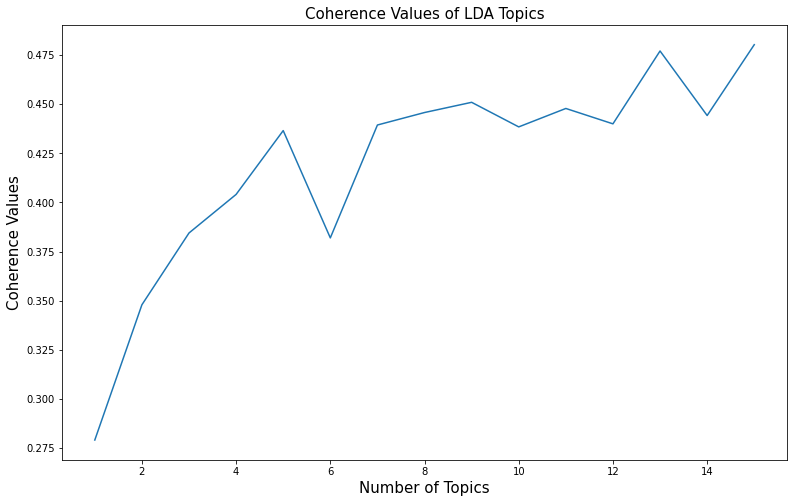

In [38]:
plt.figure(figsize=(13,8))
plt.plot(np.arange(1,16,1),coherence_values)
plt.xlabel('Number of Topics',fontsize=15)
plt.ylabel('Coherence Values',fontsize=15)
plt.title('Coherence Values of LDA Topics',fontsize=15)
plt.savefig("coherencescores1.svg")

In [46]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [49]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, bow_corpus, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.113068 -0.054483       1        1  20.200202
0      0.014587  0.035795       2        1  19.460353
4      0.021626 -0.050031       3        1  16.887612
5     -0.136350  0.072736       4        1  16.135604
3      0.099721  0.044806       5        1  10.130986
7     -0.193948  0.085936       6        1   9.644550
2      0.054265 -0.254561       7        1   4.393530
1      0.253166  0.119802       8        1   3.147163, topic_info=       Term          Freq         Total Category  logprob  loglift
10      car  55291.000000  55291.000000  Default  30.0000  30.0000
937   truck   5208.000000   5208.000000  Default  29.0000  29.0000
570    seat  11830.000000  11830.000000  Default  28.0000  28.0000
165     mpg   7460.000000   7460.000000  Default  27.0000  27.0000
162    mile  14415.000000  14415.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
326    want    312.579435   3466.589211   Topic8  -5.2709   1.0526
216   power    321.947654   4709.732934   Topic8  -5.2413   0.7757
61      top    284.508964   1716.637378   Topic8  -5.3650   1.6613
44     look    287.546139   5460.269279   Topic8  -5.3543   0.5148
150  engine    288.737326   7067.003742   Topic8  -5.3502   0.2610

[597 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
435        2  0.984941  25mpg
6762       2  0.988248  28mpg
3807       2  0.991933  30mpg
2587       5  0.996297   328i
11632      2  0.991026  35mpg
...      ...       ...    ...
115        5  0.128554   year
115        6  0.011446   year
115        7  0.061998   year
115        8  0.021938   year
8554       8  0.995920      z

[1484 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 5, 6, 4, 8, 3, 2])

In [50]:
def format_topics_sentences(lda_model,corpus):
    '''Mapping dominant topic, probability of the topic occuring, and the keywords of the original 
    review documents onto a new dataframe'''
    
    '''Returning a list that can be used to make a dataframe'''
    
    topic_list = []
    
    for i,row in enumerate(lda_model[corpus]):     
        row = sorted(row, key = lambda x:x[1],reverse=True)  
        
        for j,(topic_num,prop_topic) in enumerate(row):
            
            if j== 0 :              
                words = lda_model.show_topic(topic_num)            
                topic_keywords = ','.join([word for word,prob in words])             
                topic_list.append([int(topic_num),round(prop_topic,4),topic_keywords])               
    return topic_list

In [51]:
tmplist = format_topics_sentences(lda_model,bow_corpus)

In [52]:
document_df = pd.DataFrame(tmplist,columns=['topic_num','topicprob', 'keywords'])

In [53]:
new_car_df = pd.concat([car_df,document_df],axis=1)

In [54]:
def get_top_cars(new_car_df,topicnum,num_cars):
    return new_car_df[new_car_df.topic_num == topicnum].sort_values(['topicprob'],ascending=False)[:num_cars]

def get_top_cars_filter(new_car_df,topicnum,num_cars,carfilter):
    return new_car_df[(new_car_df.topic_num == topicnum) & (new_car_df.type == carfilter)].sort_values(['topicprob'],ascending=False)[:num_cars]

In [55]:
new_car_df.head()

vehicle  \
0  2017 Lamborghini Huracan Convertible LP 580-2 ...   
1  2012 Lamborghini Gallardo Convertible LP 560-4...   
2  2011 Lamborghini Gallardo Coupe LP 570-4 Super...   
3  2017 Jeep Cherokee SUV Altitude 4dr SUV (2.4L ...   
4  2017 Jeep Cherokee SUV Latitude 4dr SUV 4WD (2...   

                                              review  rating  text_length  \
0  bought car son love ferrari la ferrari bmw i8 ...     5.0           31   
1  many many many car r8 m3 xkr imagine test drov...     5.0           47   
2  recently purchased extremely satified performa...     5.0            7   
3  weather get hot replace battery rain replace c...     1.0           64   
4  fuel economy could better jeep come skid plate...     5.0           13   

   topic_num  topicprob                                           keywords  
0          1     0.4755  car,fun,sport,drive,it’s,turbo,one,performance...  
1          4     0.3350   car,honda,like,drive,get,love,one,year,new,would  
2          3     0.6227  car,audi,bmw,interior,drive,suv,feature,like,p...  
3          6     0.8131  car,mile,problem,dealer,issue,time,new,service...  
4          2     0.4989  truck,jeep,toyota,snow,tacoma,road,like,tundra...

In [56]:
topics = [lda_model[bow_corpus[i]] for i in range(len(car_df))]

In [57]:
def topic_prob_df(topics,num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics:
        res.loc[0,topic_weight[0]] = topic_weight[1]
    return res

In [58]:
topic_prob_df = pd.concat([topic_prob_df(topics_document, num_topics=8) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [59]:
topic_prob_df.head()

0         1         2         3         4         5         6  \
0  0.129736  0.475437  0.003912  0.128776  0.250411  0.003908  0.003910   
1  0.002607  0.157356  0.002606  0.266968  0.335453  0.106390  0.002608   
2  0.015649  0.015647  0.015633  0.622729  0.015653  0.015631  0.283429   
3  0.001926  0.001927  0.078792  0.001925  0.037455  0.001926  0.809626   
4  0.447500  0.008930  0.498847  0.008948  0.008938  0.008944  0.008953   

          7  
0  0.003910  
1  0.126012  
2  0.015629  
3  0.066423  
4  0.008940

In [60]:
topic_prob_df.rename(columns={0:'topic_1',1:'topic_2',2:'topic_3',3:'topic_4',4:'topic_5',5:'topic_6',
                              6:'topic_7',7:'topic_8'},inplace=True)
#Adding topic_prob dataframe to main dataframe
car_df_final = pd.concat([new_car_df,topic_prob_df],axis=1)
car_df_final

vehicle  \
0      2017 Lamborghini Huracan Convertible LP 580-2 ...   
1      2012 Lamborghini Gallardo Convertible LP 560-4...   
2      2011 Lamborghini Gallardo Coupe LP 570-4 Super...   
3      2017 Jeep Cherokee SUV Altitude 4dr SUV (2.4L ...   
4      2017 Jeep Cherokee SUV Latitude 4dr SUV 4WD (2...   
...                                                  ...   
27367  2013 Audi TTS Coupe Premium Plus quattro 2dr C...   
27368  2016 Audi TTS Coupe quattro 2dr Coupe AWD (2.0...   
27369  2016 Audi TTS Coupe quattro 2dr Coupe AWD (2.0...   
27370  2016 Audi TTS Coupe quattro 2dr Coupe AWD (2.0...   
27371  2014 Audi TTS Convertible quattro 2dr Converti...   

                                                  review  rating  text_length  \
0      bought car son love ferrari la ferrari bmw i8 ...     5.0           31   
1      many many many car r8 m3 xkr imagine test drov...     5.0           47   
2      recently purchased extremely satified performa...     5.0            7   
3      weather get hot replace battery rain replace c...     1.0           64   
4      fuel economy could better jeep come skid plate...     5.0           13   
...                                                  ...     ...          ...   
27367  ive tt since feel unique one owns one city lov...     4.0           34   
27368  audi version porsche probably cayman closest c...     5.0           53   
27369  ready pay close sticker sticker however every ...     5.0           15   
27370  disclaimer purchased tt information still pert...     4.0          457   
27371  traded corvette c6 audi tt far better car quic...     5.0           71   

       topic_num  topicprob  \
0              1     0.4755   
1              4     0.3350   
2              3     0.6227   
3              6     0.8131   
4              2     0.4989   
...          ...        ...   
27367          4     0.6085   
27368          3     0.4973   
27369          1     0.3875   
27370          5     0.5323   
27371          1     0.4122   

                                                keywords   topic_1   topic_2  \
0      car,fun,sport,drive,it’s,turbo,one,performance...  0.129736  0.475437   
1       car,honda,like,drive,get,love,one,year,new,would  0.002607  0.157356   
2      car,audi,bmw,interior,drive,suv,feature,like,p...  0.015649  0.015647   
3      car,mile,problem,dealer,issue,time,new,service...  0.001926  0.001927   
4      truck,jeep,toyota,snow,tacoma,road,like,tundra...  0.447500  0.008930   
...                                                  ...       ...       ...   
27367   car,honda,like,drive,get,love,one,year,new,would  0.066828  0.306843   
27368  car,audi,bmw,interior,drive,suv,feature,like,p...  0.002318  0.087888   
27369  car,fun,sport,drive,it’s,turbo,one,performance...  0.308303  0.387338   
27370  seat,rear,back,front,like,door,wheel,driver,ca...  0.178868  0.049413   
27371  car,fun,sport,drive,it’s,turbo,one,performance...  0.306508  0.412257   

        topic_3   topic_4   topic_5   topic_6   topic_7   topic_8  
0      0.003912  0.128776  0.250411  0.003908  0.003910  0.003910  
1      0.002606  0.266968  0.335453  0.106390  0.002608  0.126012  
2      0.015633  0.622729  0.015653  0.015631  0.283429  0.015629  
3      0.078792  0.001925  0.037455  0.001926  0.809626  0.066423  
4      0.498847  0.008948  0.008938  0.008944  0.008953  0.008940  
...         ...       ...       ...       ...       ...       ...  
27367  0.003575  0.003575  0.608455  0.003576  0.003574  0.003574  
27368  0.002317  0.497326  0.002319  0.403193  0.002320  0.002320  
27369  0.007813  0.265260  0.007825  0.007818  0.007822  0.007821  
27370  0.000273  0.119287  0.006313  0.532389  0.002538  0.110919  
27371  0.001738  0.095326  0.001739  0.178956  0.001738  0.001737  

[27372 rows x 15 columns]

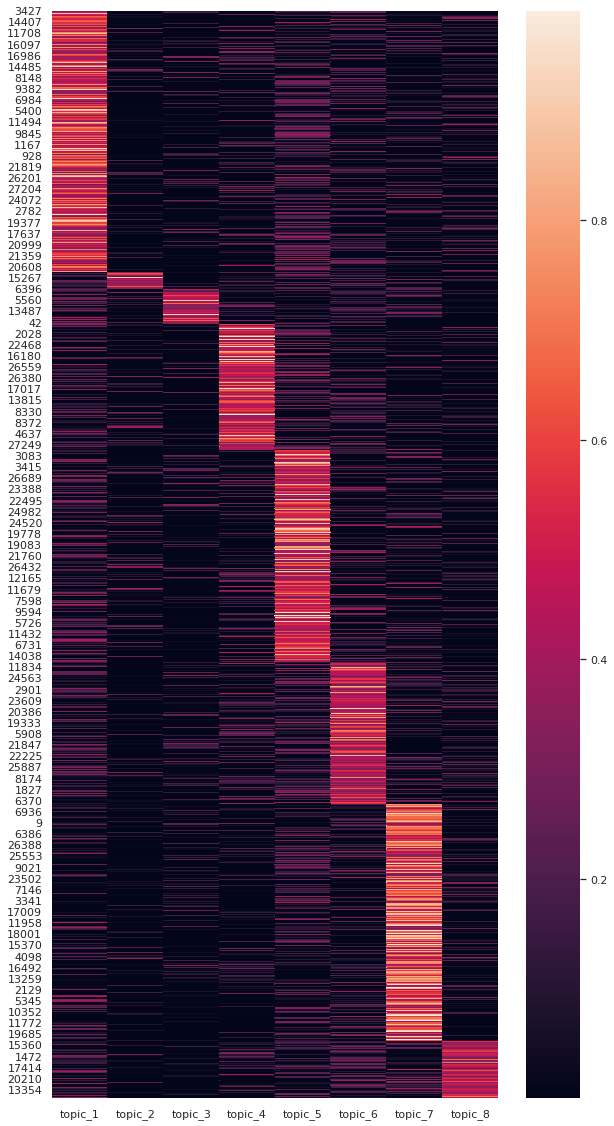

In [61]:
%matplotlib inline
import seaborn as sns; sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(topic_prob_df.loc[topic_prob_df.idxmax(axis=1).sort_values().index])

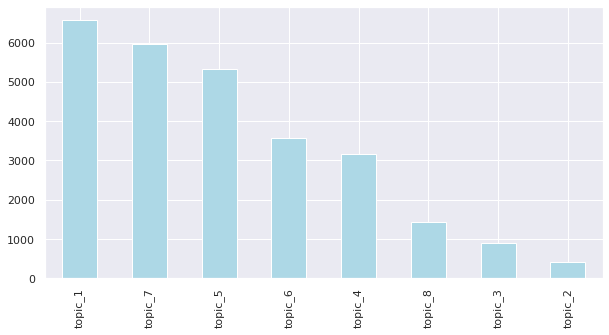

In [62]:
sns.set(rc={'figure.figsize':(10,5)})
topic_prob_df.idxmax(axis=1).value_counts().sort_values(ascending=False).plot.bar(color='lightblue')

In [63]:
topics = lda_model.show_topics(formatted=False)

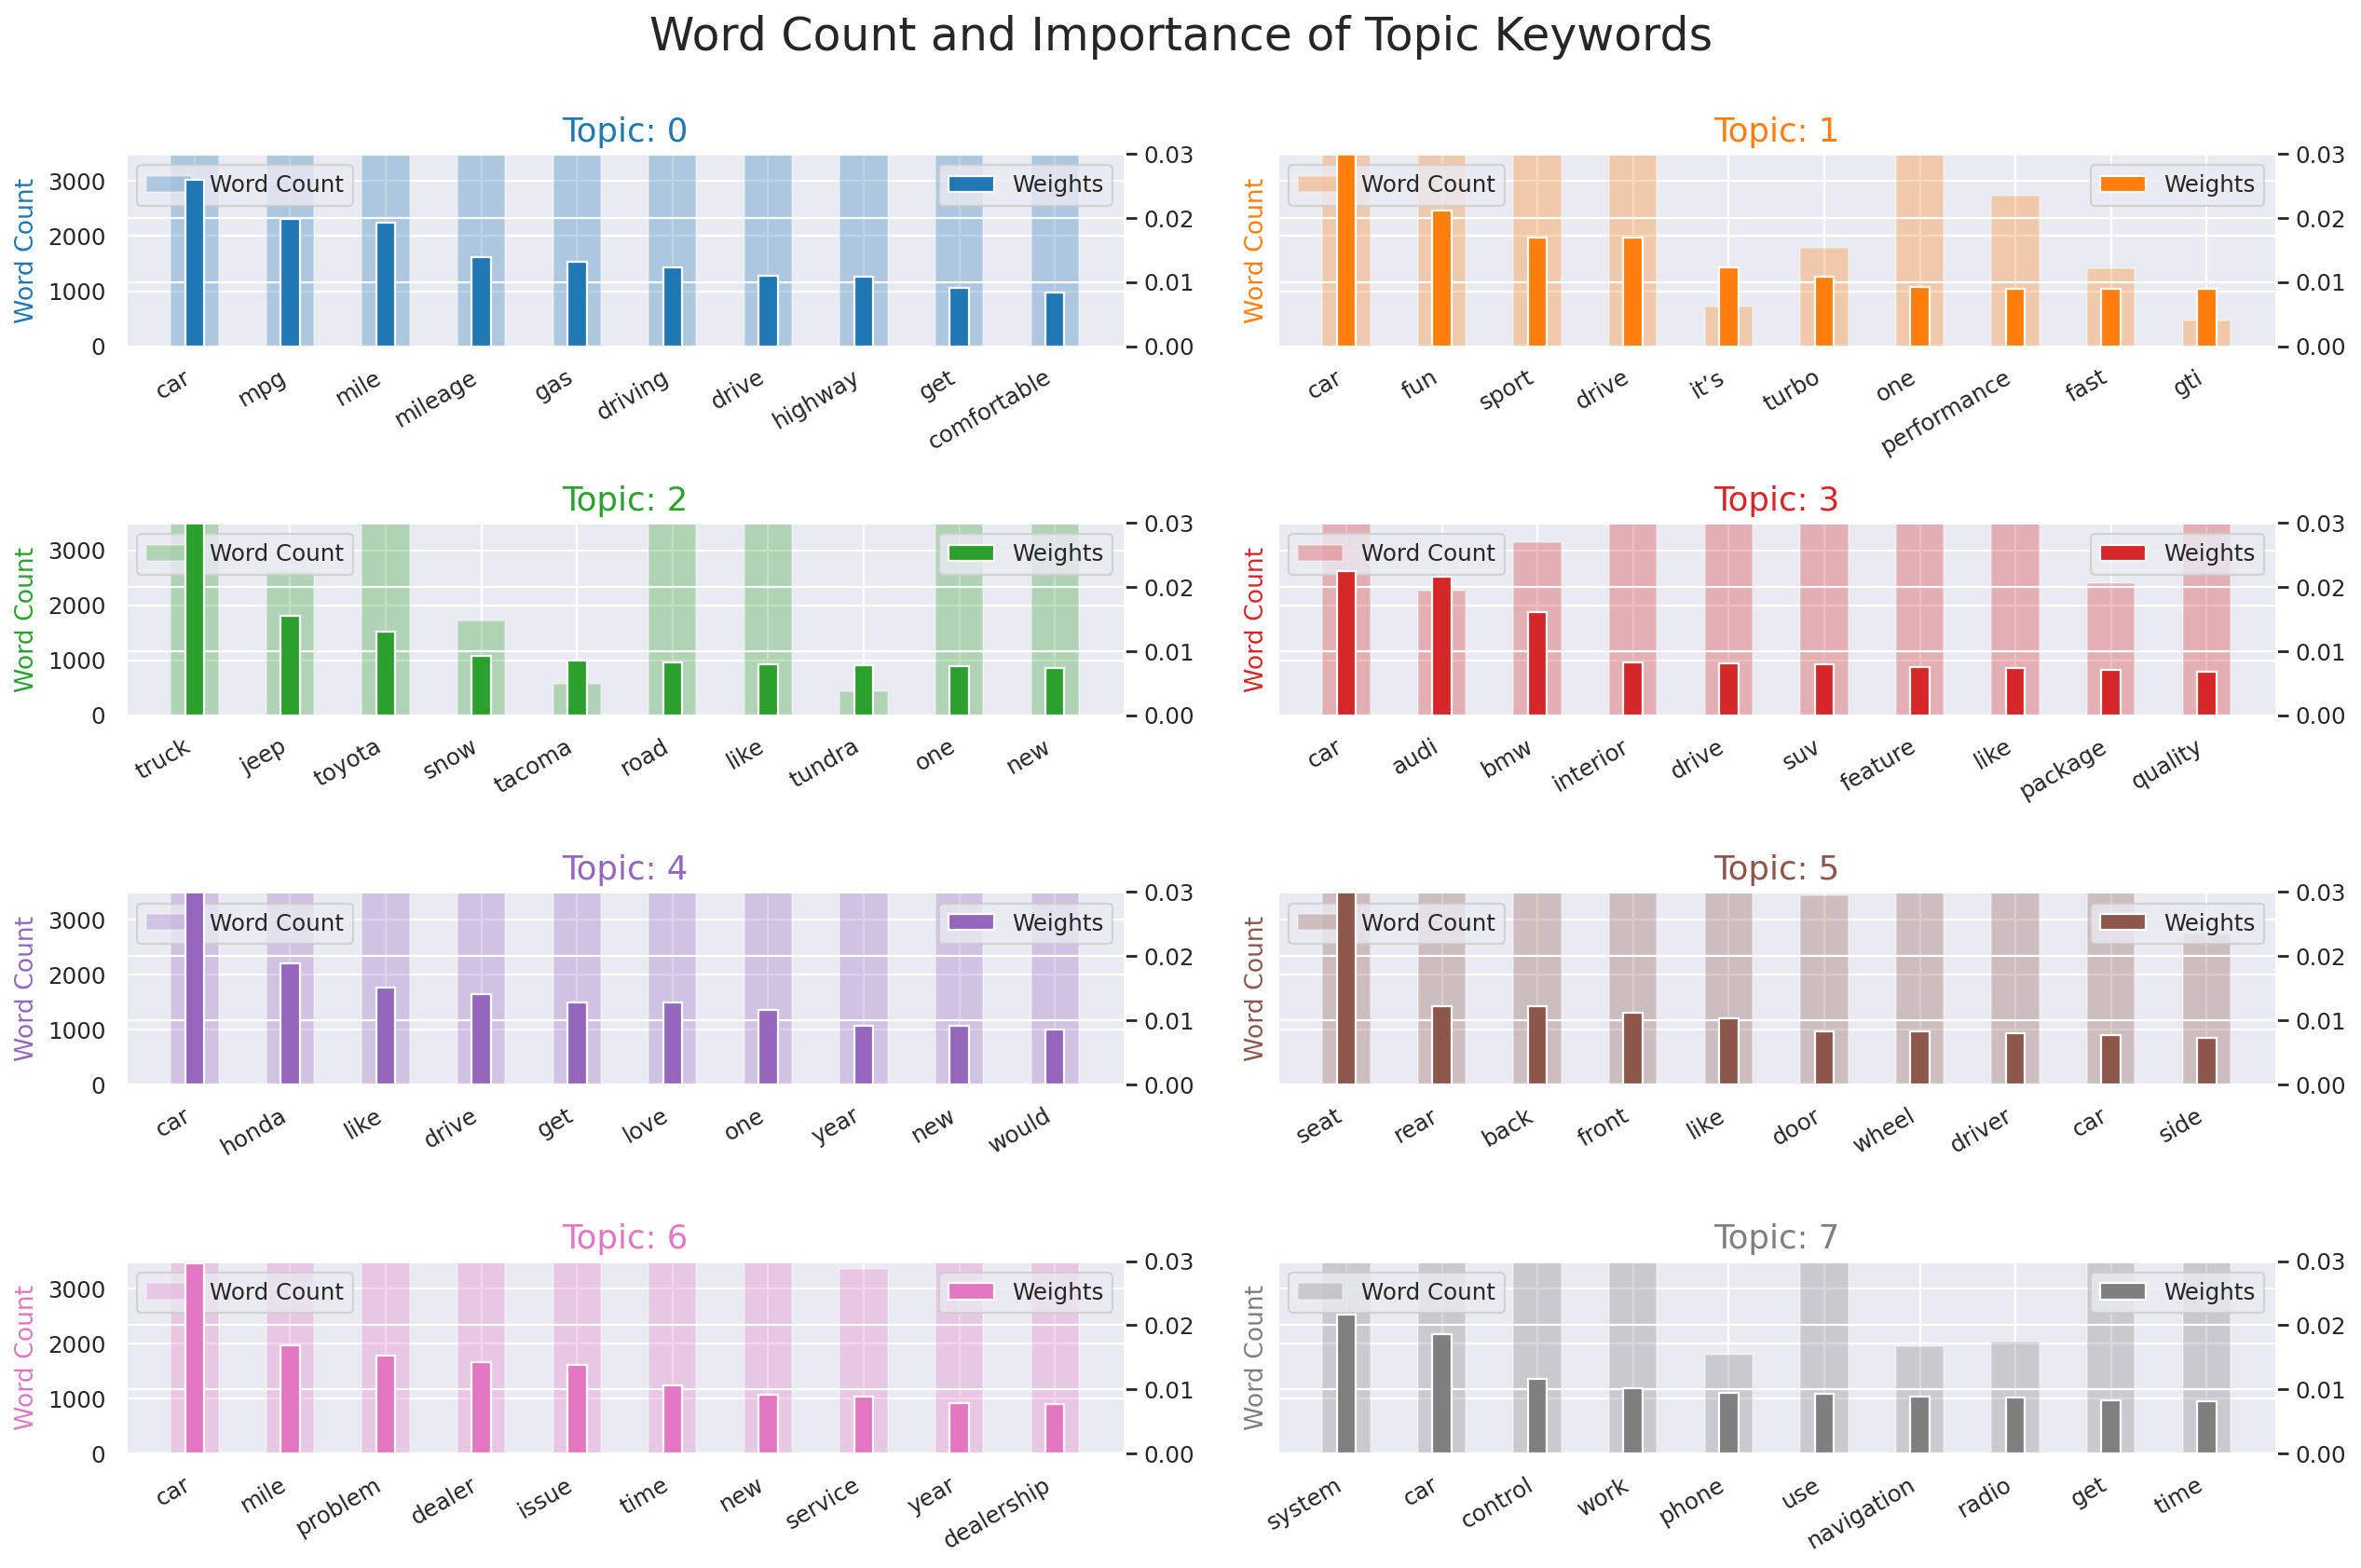

In [64]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in processed_docs for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [65]:
car_df_final.head()

vehicle  \
0  2017 Lamborghini Huracan Convertible LP 580-2 ...   
1  2012 Lamborghini Gallardo Convertible LP 560-4...   
2  2011 Lamborghini Gallardo Coupe LP 570-4 Super...   
3  2017 Jeep Cherokee SUV Altitude 4dr SUV (2.4L ...   
4  2017 Jeep Cherokee SUV Latitude 4dr SUV 4WD (2...   

                                              review  rating  text_length  \
0  bought car son love ferrari la ferrari bmw i8 ...     5.0           31   
1  many many many car r8 m3 xkr imagine test drov...     5.0           47   
2  recently purchased extremely satified performa...     5.0            7   
3  weather get hot replace battery rain replace c...     1.0           64   
4  fuel economy could better jeep come skid plate...     5.0           13   

   topic_num  topicprob                                           keywords  \
0          1     0.4755  car,fun,sport,drive,it’s,turbo,one,performance...   
1          4     0.3350   car,honda,like,drive,get,love,one,year,new,would   
2          3     0.6227  car,audi,bmw,interior,drive,suv,feature,like,p...   
3          6     0.8131  car,mile,problem,dealer,issue,time,new,service...   
4          2     0.4989  truck,jeep,toyota,snow,tacoma,road,like,tundra...   

    topic_1   topic_2   topic_3   topic_4   topic_5   topic_6   topic_7  \
0  0.129736  0.475437  0.003912  0.128776  0.250411  0.003908  0.003910   
1  0.002607  0.157356  0.002606  0.266968  0.335453  0.106390  0.002608   
2  0.015649  0.015647  0.015633  0.622729  0.015653  0.015631  0.283429   
3  0.001926  0.001927  0.078792  0.001925  0.037455  0.001926  0.809626   
4  0.447500  0.008930  0.498847  0.008948  0.008938  0.008944  0.008953   

    topic_8  
0  0.003910  
1  0.126012  
2  0.015629  
3  0.066423  
4  0.008940

In [66]:
topics = ['Comfort','Price','Reliability','Technology','Car Handling','Trucks','Fuel Efficiency','Horsepower']

In [68]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.026*"car" + 0.020*"mpg" + 0.019*"mile" + 0.014*"mileage" + 0.013*"gas" + 0.012*"driving" + 0.011*"drive" + 0.011*"highway" + 0.009*"get" + 0.008*"comfortable"
Topic: 1 Word: 0.056*"car" + 0.021*"fun" + 0.017*"sport" + 0.017*"drive" + 0.012*"it’s" + 0.011*"turbo" + 0.009*"one" + 0.009*"performance" + 0.009*"fast" + 0.009*"gti"
Topic: 2 Word: 0.061*"truck" + 0.016*"jeep" + 0.013*"toyota" + 0.009*"snow" + 0.009*"tacoma" + 0.008*"road" + 0.008*"like" + 0.008*"tundra" + 0.008*"one" + 0.007*"new"
Topic: 3 Word: 0.022*"car" + 0.022*"audi" + 0.016*"bmw" + 0.008*"interior" + 0.008*"drive" + 0.008*"suv" + 0.007*"feature" + 0.007*"like" + 0.007*"package" + 0.007*"quality"
Topic: 4 Word: 0.062*"car" + 0.019*"honda" + 0.015*"like" + 0.014*"drive" + 0.013*"get" + 0.013*"love" + 0.012*"one" + 0.009*"year" + 0.009*"new" + 0.009*"would"
Topic: 5 Word: 0.032*"seat" + 0.012*"rear" + 0.012*"back" + 0.011*"front" + 0.010*"like" + 0.008*"door" + 0.008*"wheel" + 0.008*"driver" + 0.008*"car" 

In [69]:
stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [70]:
unseen_document = 'fuel efficient '

bow_vector = dictionary.doc2bow(preprocess(unseen_document))
sorted(lda_model[bow_vector], key=lambda x:x[1],reverse=True)[0][0]

0

In [71]:
get_top_cars(car_df_final,0,10)

vehicle  \
3380   2013 Ford Focus Sedan SE 4dr Sedan (2.0L 4cyl 5M)   
21427  2012 Volkswagen Jetta Sedan SE PZEV 4dr Sedan ...   
7142      2013 Kia Sorento SUV EX 4dr SUV (3.5L 6cyl 6A)   
7496   2016 Kia Sorento SUV SX 4dr SUV AWD (3.3L 6cyl...   
10468  2018 Hyundai Elantra Sedan Value Edition 4dr S...   
6641   2012 Kia Forte Hatchback EX 4dr Hatchback (2.0...   
7609   2017 Kia Sportage SUV SX 4dr SUV AWD (2.0L 4cy...   
4849   2016 Ford Escape SUV Titanium 4dr SUV (1.6L 4c...   
7435      2014 Kia Sorento SUV SX 4dr SUV (3.3L 6cyl 6A)   
15740  2011 BMW X5 SUV xDrive50i 4dr SUV AWD (4.4L 8c...   

                                                  review  rating  text_length  \
3380   bought focus back february april mile commute ...     5.0           57   
21427  bought certified pre owned 5l se convenience w...     4.0           52   
7142   chose 5l engine cy little lazy much difference...     4.0           50   
7496   wife looking practical road car extended weeke...     5.0           49   
10468  owned little seven week speak overall reliabil...     5.0           42   
6641   purchased kia forte hatchback really wagon mil...     4.0           42   
7609   took delivery sportage sx labor day weekend op...     5.0           38   
4849   escape driven infrequently le mile odometer on...     5.0           37   
7435   sorento cylinder pretty peppy pretty gas milea...     5.0           35   
15740  car spacious interior roomy drive excellent ha...     5.0           34   

       topic_num  topicprob  \
3380           0     0.9849   
21427          0     0.9835   
7142           0     0.9828   
7496           0     0.9818   
10468          0     0.9796   
6641           0     0.9796   
7609           0     0.9775   
4849           0     0.9769   
7435           0     0.9757   
15740          0     0.9750   

                                                keywords   topic_1   topic_2  \
3380   car,mpg,mile,mileage,gas,driving,drive,highway...  0.984897  0.002156   
21427  car,mpg,mile,mileage,gas,driving,drive,highway...  0.983469  0.002361   
7142   car,mpg,mile,mileage,gas,driving,drive,highway...  0.982814  0.002456   
7496   car,mpg,mile,mileage,gas,driving,drive,highway...  0.980570  0.002504   
10468  car,mpg,mile,mileage,gas,driving,drive,highway...  0.979626  0.002910   
6641   car,mpg,mile,mileage,gas,driving,drive,highway...  0.979630  0.002908   
7609   car,mpg,mile,mileage,gas,driving,drive,highway...  0.977545  0.003208   
4849   car,mpg,mile,mileage,gas,driving,drive,highway...  0.976943  0.003292   
7435   car,mpg,mile,mileage,gas,driving,drive,highway...  0.975672  0.003476   
15740  car,mpg,mile,mileage,gas,driving,drive,highway...  0.974969  0.003579   

        topic_3   topic_4   topic_5   topic_6   topic_7   topic_8  
3380   0.002156  0.002156  0.002160  0.002159  0.002159  0.002156  
21427  0.002361  0.002362  0.002363  0.002363  0.002361  0.002360  
7142   0.002454  0.002456  0.002457  0.002455  0.002456  0.002453  
7496   0.002503  0.004408  0.002504  0.002505  0.002504  0.002502  
10468  0.002911  0.002911  0.002912  0.002911  0.002910  0.002909  
6641   0.002909  0.002910  0.002912  0.002909  0.002912  0.002910  
7609   0.003206  0.003209  0.003208  0.003207  0.003211  0.003207  
4849   0.003294  0.003294  0.003296  0.003294  0.003295  0.003292  
7435   0.003478  0.003475  0.003476  0.003475  0.003474  0.003473  
15740  0.003576  0.003579  0.003575  0.003575  0.003573  0.003573

In [72]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider
from bokeh.layouts import column
from bokeh.palettes import all_palettes
from bokeh.models import ColumnDataSource, LabelSet
from sklearn.manifold import TSNE
output_notebook()

In [73]:
hm = np.array([[y for (x,y) in lda_model[bow_corpus[i]]] for i in range(len(bow_corpus))])

In [74]:
from sklearn.manifold import TSNE

# a t-SNE model
# angle value close to 1 means sacrificing accuracy for speed
# pca initializtion usually leads to better results 
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')

# 20-D -> 2-D
tsne_lda = tsne_model.fit_transform(hm)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 27372 samples in 0.043s...
[t-SNE] Computed neighbors for 27372 samples in 2.650s...
[t-SNE] Computed conditional probabilities for sample 1000 / 27372
[t-SNE] Computed conditional probabilities for sample 2000 / 27372
[t-SNE] Computed conditional probabilities for sample 3000 / 27372
[t-SNE] Computed conditional probabilities for sample 4000 / 27372
[t-SNE] Computed conditional probabilities for sample 5000 / 27372
[t-SNE] Computed conditional probabilities for sample 6000 / 27372
[t-SNE] Computed conditional probabilities for sample 7000 / 27372
[t-SNE] Computed conditional probabilities for sample 8000 / 27372
[t-SNE] Computed conditional probabilities for sample 9000 / 27372
[t-SNE] Computed conditional probabilities for sample 10000 / 27372
[t-SNE] Computed conditional probabilities for sample 11000 / 27372
[t-SNE] Computed conditional probabilities for sample 12000 / 27372
[t-SNE] Computed conditional probabilities for sam

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.036461
[t-SNE] KL divergence after 1000 iterations: 2.113155


In [75]:
tsne_lda_df = pd.DataFrame(tsne_lda, columns =['x','y'])

In [76]:
tsne_lda_df['topics'] = hm.argmax(axis=1)

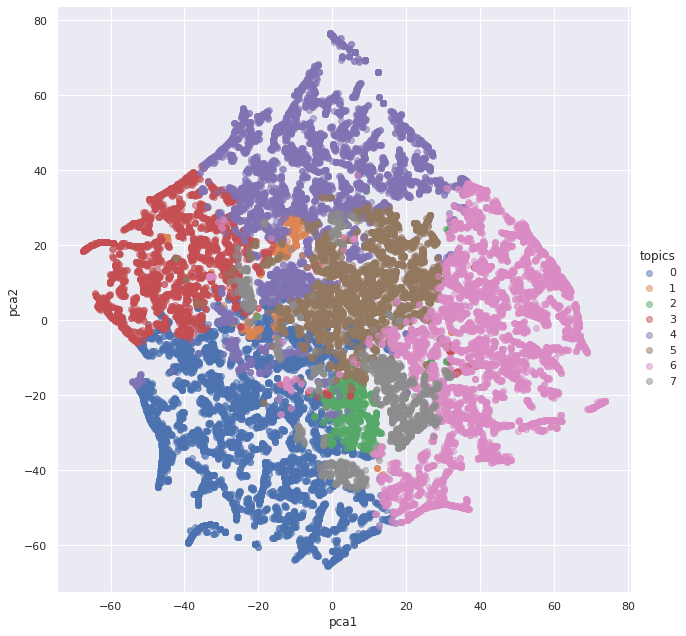

In [77]:
sns.lmplot(x='x',y='y',data = tsne_lda_df, hue ='topics',fit_reg=False,legend=True,height=9, scatter_kws={'alpha':0.5})
plt.xlabel('pca1')
plt.ylabel('pca2')
plt.savefig("TSNE.svg")

In [78]:
tsne = TSNE(random_state=2017, perplexity=30)
tsne_embedding = tsne.fit_transform(hm)
tsne_embedding = pd.DataFrame(tsne_embedding, columns=['x','y'])
tsne_embedding['hue'] = hm.argmax(axis=1)
tsne_embedding.hue.unique()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


array([1, 4, 3, 6, 2, 5, 7, 0])

In [79]:
colors = [all_palettes['Set1'][8][i] for i in tsne_embedding.hue]

In [80]:
source = ColumnDataSource(
        data=dict(
            x = tsne_embedding.x,
            y = tsne_embedding.y,
            colors = [all_palettes['Set1'][9][i] for i in tsne_embedding.hue],
            alpha = [0.9] * tsne_embedding.shape[0],
            size = [7] * tsne_embedding.shape[0],
            label= ['Topic 1','Topic 2','Topic 3', 'Topic 4','Topic 5','Topic 6' , 'Topic 7', 'Topic 8']
        )
    )
tools_tsne = ['pan', 'wheel_zoom', 'reset']
plot_tsne = figure(plot_width=700, plot_height=700, tools=tools_tsne, title='Cars')
plot_tsne.circle('x', 'y', size='size', fill_color='colors', legend='label',  
                 alpha='alpha', line_alpha=0, line_width=0.01, source=source, name="df")

GlyphRenderer(id='1032', ...)

In [81]:
layout = column(plot_tsne)
show(layout)

In [82]:
unseen_document = 'a big car that has a lot of space'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
topic_num = sorted(lda_model[bow_vector], key=lambda x:x[1],reverse=True)[0][0]
print(topic_num)

5


In [83]:
topic_num

5

In [85]:
car_df_final.loc[(car_df_final.vehicle.str.contains('SUV'),'type')] = 'suv'
car_df_final.loc[(car_df_final.vehicle.str.contains('Convertible'),'type')] = 'convertible'
car_df_final.loc[(car_df_final.vehicle.str.contains('Sedan'),'type')] = 'sedan';
car_df_final.loc[(car_df_final.vehicle.str.contains('Hatchback'),'type')] = 'hatchback';
car_df_final.loc[(car_df_final.vehicle.str.contains('SportWagen'),'type')] = 'hatchback';
car_df_final.loc[(car_df_final.vehicle.str.contains('Wagon'),'type')] = 'hatchback';
car_df_final.loc[(car_df_final.vehicle.str.contains('Van'),'type')] = 'van'
car_df_final.loc[(car_df_final.vehicle.str.contains('Minivan'),'type')] = 'van'
car_df_final.loc[(car_df_final.vehicle.str.contains('Coupe'),'type')] = 'coupe'
car_df_final.loc[(car_df_final.vehicle.str.contains('GMC'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Honda Ridgeline'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Chevrolet Silverado'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Toyota Tacoma'),'type')] = 'truck' 
car_df_final.loc[(car_df_final.vehicle.str.contains('Toyota Tundra'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Ford F-150'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains(' F-450'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains(' Ford F-250'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Ford F-350'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Ford Ranger'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Nissan Titan'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Nissan Frontier '),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Ram'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Suzuki Equator'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Chevrolet Avalanche'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Chevrolet Colorado'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Chevrolet Black'),'type')] = 'truck'

In [86]:
car_df_final[car_df_final.vehicle == '2017 Acura RDX SUV 4dr SUV (3.5L 6cyl 6A)']['topic_num']

Series([], Name: topic_num, dtype: int64)

In [87]:
get_top_cars_filter(car_df_final,0,10,'suv')

vehicle  \
7142      2013 Kia Sorento SUV EX 4dr SUV (3.5L 6cyl 6A)   
7496   2016 Kia Sorento SUV SX 4dr SUV AWD (3.3L 6cyl...   
7609   2017 Kia Sportage SUV SX 4dr SUV AWD (2.0L 4cy...   
4849   2016 Ford Escape SUV Titanium 4dr SUV (1.6L 4c...   
7435      2014 Kia Sorento SUV SX 4dr SUV (3.3L 6cyl 6A)   
15740  2011 BMW X5 SUV xDrive50i 4dr SUV AWD (4.4L 8c...   
5039     2011 Ford Escape SUV XLS 4dr SUV (2.5L 4cyl 5M)   
11461  2011 Hyundai Tucson SUV Limited 4dr SUV (2.4L ...   
7555   2013 Kia Sportage SUV SX 4dr SUV AWD (2.0L 4cy...   
4284   2014 Ford Edge SUV Limited 4dr SUV (3.5L 6cyl 6A)   

                                                  review  rating  text_length  \
7142   chose 5l engine cy little lazy much difference...     4.0           50   
7496   wife looking practical road car extended weeke...     5.0           49   
7609   took delivery sportage sx labor day weekend op...     5.0           38   
4849   escape driven infrequently le mile odometer on...     5.0           37   
7435   sorento cylinder pretty peppy pretty gas milea...     5.0           35   
15740  car spacious interior roomy drive excellent ha...     5.0           34   
5039   base model 2wd spd manual far problem excellen...     3.0           29   
11461  limited meet expectation fun drive use comfort...     5.0           30   
7555   terrrible mileage turbo sportage 600km fuel co...     4.0           28   
4284   owned edge week mile already issue speak car s...     4.0           27   

       topic_num  topicprob  \
7142           0     0.9828   
7496           0     0.9818   
7609           0     0.9775   
4849           0     0.9769   
7435           0     0.9757   
15740          0     0.9750   
5039           0     0.9708   
11461          0     0.9698   
7555           0     0.9698   
4284           0     0.9687   

                                                keywords   topic_1   topic_2  \
7142   car,mpg,mile,mileage,gas,driving,drive,highway...  0.982814  0.002456   
7496   car,mpg,mile,mileage,gas,driving,drive,highway...  0.980570  0.002504   
7609   car,mpg,mile,mileage,gas,driving,drive,highway...  0.977545  0.003208   
4849   car,mpg,mile,mileage,gas,driving,drive,highway...  0.976943  0.003292   
7435   car,mpg,mile,mileage,gas,driving,drive,highway...  0.975672  0.003476   
15740  car,mpg,mile,mileage,gas,driving,drive,highway...  0.974969  0.003579   
5039   car,mpg,mile,mileage,gas,driving,drive,highway...  0.970788  0.004172   
11461  car,mpg,mile,mileage,gas,driving,drive,highway...  0.970008  0.004040   
7555   car,mpg,mile,mileage,gas,driving,drive,highway...  0.969795  0.004316   
4284   car,mpg,mile,mileage,gas,driving,drive,highway...  0.968713  0.004468   

        topic_3   topic_4   topic_5   topic_6   topic_7   topic_8 type  
7142   0.002454  0.002456  0.002457  0.002455  0.002456  0.002453  suv  
7496   0.002503  0.004408  0.002504  0.002505  0.002504  0.002502  suv  
7609   0.003206  0.003209  0.003208  0.003207  0.003211  0.003207  suv  
4849   0.003294  0.003294  0.003296  0.003294  0.003295  0.003292  suv  
7435   0.003478  0.003475  0.003476  0.003475  0.003474  0.003473  suv  
15740  0.003576  0.003579  0.003575  0.003575  0.003573  0.003573  suv  
5039   0.004175  0.004171  0.004175  0.004172  0.004175  0.004172  suv  
11461  0.004040  0.004036  0.004043  0.004038  0.004038  0.005759  suv  
7555   0.004314  0.004314  0.004319  0.004313  0.004316  0.004314  suv  
4284   0.004467  0.004471  0.004469  0.004470  0.004474  0.004467  suv

In [118]:
#given a word in text

unseen_document = 'I need a offroader'
tmp2 = preprocess(unseen_document)
automobile_types =['truck','suv','convertible','sedan','hatchback','van','coupe']
word_tmp = []
for word in tmp2:
    if word in automobile_types:
        word_tmp.append(word)

In [119]:
list(get_top_cars_filter(car_df_final,topic_num,10,'suv').vehicle)

['2017 Toyota Highlander SUV XLE 4dr SUV AWD (3.5L 6cyl 8A)',
 '2016 Mercedes-Benz GLA-Class SUV GLA 250 4MATIC 4dr SUV AWD (2.0L 4cyl Turbo 7AM)',
 '2018 Volkswagen Tiguan SUV SEL 4Motion 4dr SUV AWD (2.0L 4cyl Turbo 8A)',
 '2018 Toyota RAV4 SUV LE 4dr SUV AWD (2.5L 4cyl 6A)',
 '2013 Honda CR-V SUV EX 4dr SUV (2.4L 4cyl 5A)',
 '2013 Honda CR-V SUV EX 4dr SUV (2.4L 4cyl 5A)',
 '2016 Honda CR-V SUV LX 4dr SUV (2.4L 4cyl CVT)',
 '2015 Honda CR-V SUV EX 4dr SUV AWD (2.4L 4cyl CVT)',
 '2014 Hyundai Tucson SUV Limited 4dr SUV (2.4L 4cyl 6A)',
 '2017 Jeep Compass SUV Sport SE w/Prod. End 02/17 4dr SUV (2.0L 4cyl CVT)']

In [120]:
#Writing a function to determine which function to use based on the input user text:
if len(word_tmp) == 0:
    new = get_top_cars(car_df_final,topic_num,10).vehicle.values
else:   
    new = get_top_cars_filter(car_df_final,topic_num,10,word_tmp[0]).vehicle.values

In [121]:
print(new)

['2016 Nissan Maxima Sedan Platinum 4dr Sedan (3.5L 6cyl CVT)'
 '2017 Toyota Highlander SUV XLE 4dr SUV AWD (3.5L 6cyl 8A)'
 '2011 Ford Taurus SHO SHO 4dr Sedan AWD (3.5L 6cyl Turbo 6A)'
 '2016 Mercedes-Benz GLA-Class SUV GLA 250 4MATIC 4dr SUV AWD (2.0L 4cyl Turbo 7AM)'
 '2018 Volkswagen Tiguan SUV SEL 4Motion 4dr SUV AWD (2.0L 4cyl Turbo 8A)'
 '2013 Toyota Venza Wagon XLE 4dr Wagon (3.5L 6cyl 6A)'
 '2016 Audi A5 Coupe 2.0T Premium quattro 2dr Coupe AWD (2.0L 4cyl Turbo 8A)'
 '2018 Toyota RAV4 SUV LE 4dr SUV AWD (2.5L 4cyl 6A)'
 '2015 Mercedes-Benz CLS-Class Sedan CLS 400 4dr Sedan (3.0L 6cyl Turbo 7A)'
 '2013 Honda CR-V SUV EX 4dr SUV (2.4L 4cyl 5A)']
